# DO NOT RUN THIS NOTEBOOK LOCALLY
## This notebook is set up to run on Google dataproc

# wk8 Demo - Advanced Spark - Pipelines and Optimizations with DataFrames
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__

So far we've been using Spark's low level APIs. In particular, we've been using the RDD (Resilient Distiributed Datasets) API to implement Machine Learning algorithms from scratch. This week we're going to take a look at how Spark is used in a production setting. We'll look at DataFrames, SQL, and UDFs (User Defined Functions).  As discussed previously, we still need to understand the internals of Spark and MapReduce in general to write efficient and scalable code.

In class today we'll get some practice working with larger data sets in Spark. We'll start with an introduction to efficiently storing data and approach a large dataset for analysis. After that we'll discuss a ranking problem which was covered in Chapter 6 of the High Performance Spark book and how we can apply that to our problem. We'll follow up with a discussion on things that could be done to make this more effiicent.
* ... __describe__ differences between data serialization formats.
* ... __choose__ a data serialization format based on use case.
* ... __change__ submission arguements for a `SparkSession`.
* ... __set__ custom configuration for a `SparkSession`.
* ... __describe__ and __create__ a data pipeline for analysis.
* ... __use__ a user defined function (UDF).
* ... __understand__ feature engineering and aggregations in Spark.

__`Additional Resources:`__ Writing performant code in Spark requires a lot of thought. Holden's High Performance Spark book covers this topic very well. In addition, Spark - The Definitive Guide, by Bill Chambers and Matei Zaharia, provides some recent developments.

### Notebook Set-Up

This is running on dataproc with the following setup

```{bash}
BUCKET="w261-bucket"
CLUSTER="w261-demo"
PROJECT="w261-216504"
JUPYTER_PORT="8123"
PORT="10000"
ZONE=$(gcloud config get-value compute/zone)

# CREATE DATAPROC CLUSTER
gcloud dataproc clusters create ${CLUSTER} \
    --metadata "JUPYTER_PORT=${JUPYTER_PORT}" \
    --metadata "JUPYTER_CONDA_PACKAGES=numpy:pandas:scipy:pyarrow" \
    --metadata "JUPYTER_CONDA_CHANNELS=conda-forge" \
    --project ${PROJECT} \
    --bucket ${BUCKET} \
    --image-version "1.3.10-deb9" \
    --initialization-actions \
       gs://dataproc-initialization-actions/jupyter/jupyter.sh \
    --num-preemptible-workers=4 \
    --num-workers=2 \
    --worker-machine-type=n1-standard-8 \
    --master-machine-type=n1-standard-8
    
# CREATE SOCKS PROXY
gcloud compute ssh ${CLUSTER}-m \
    --project=${PROJECT} \
    --zone=${ZONE}  \
    --ssh-flag="-D" \
    --ssh-flag=${PORT} \
    --ssh-flag="-N"

```
--------

```
# USE SOCKS PROXY (if your local computer is linux)
/usr/bin/google-chrome \
  --proxy-server="socks5://localhost:${PORT}" \
  --user-data-dir=/tmp/${CLUSTER}-m   

# USE SOCKS PROXY (if your local computer is a mac)
/Applications/Google\ Chrome.app/Contents/MacOS/Google\ Chrome \
  --proxy-server="socks5://localhost:${PORT}" \
  --user-data-dir=/tmp/${CLUSTER}-m  

# MORE INFO ON SETTING UP SOCKS PROXIES IN GCP:
# https://cloud.google.com/solutions/connecting-securely#socks-proxy-over-ssh
```

In [20]:
# imports
import re
import os
import numpy as np
import pandas as pd

### Load the data
Today we'll be using GSOD weather station data, avaliable from Google in BigQuery.

Since this is a decent sized dataset (21 GB uncompressed) we won't be running code, but rather reviewing the process.

In [2]:
# Get data from BigQuery into Google Cloud Storage as GZIP compressed CSV files
!bq --location=US extract --compression GZIP 'bigquery-public-data:samples.gsod' gs://w261-bucket/gsod/gsod-*.csv.gz
!bq --location=US extract --compression GZIP 'bigquery-public-data:noaa_gsod.stations' gs://w261-bucket/gsod/stations.csv.gz

Waiting on bqjob_r48f1a0402fac4c3c_000001694ef31157_1 ... (50s) Current status: DONE   
Waiting on bqjob_r68977011483455a1_000001694ef3e414_1 ... (1s) Current status: DONE   


### Initialize Spark

In [3]:
spark

In [21]:
# Here we show how to do a custom configuration
sc = spark.sparkContext

In [22]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [6]:
sc.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'w261-demo-m'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.databricks_spark-avro_2.11-4.0.0.jar,/root/.ivy2/jars/org.slf4j_slf4j-api-1.7.5.jar,/root/.ivy2/jars/org.apache.avro_avro-1.7.6.jar,/root/.ivy2/jars/org.codehaus.jackson_jackson-core-asl-1.9.13.jar,/root/.ivy2/jars/org.codehaus.jackson_jackson-mapper-asl-1.9.13.jar,/root/.ivy2/jars/com.thoughtworks.paranamer_paranamer-2.3.jar,/root/.ivy2/jars/org.xerial.snappy_snappy-java-1.0.5.jar,/root/.ivy2/jars/org.apache.commons_commons-compress-1.4.1.jar,/root/.ivy2/jars/org.tukaani_xz-1.0.jar'),
 ('spark.yarn.am.memory', '640m'),
 ('spark.executor.cores', '4'),
 ('spark.driver.port', '43385'),
 ('spark.executor.instances', '2'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.maxResultSize', '3840m'),
 ('spark.submit.deployMode', 'client'),
 (

# Exercise 1. Structured API - Datasets, DataFrames, and SQL Tables and Views

A Dataset is a distributed collection of data. Datasets provide the benefits of RDDs (strong typing, ability to use powerful lambda functions) with the benefits of Spark SQL’s optimized execution engine. A Dataset can be constructed from JVM objects and then manipulated using functional transformations (map, flatMap, filter, etc.). The Dataset API is available in Scala and Java. Python does not have the support for the Dataset API. But due to Python’s dynamic nature, many of the benefits of the Dataset API are already available (i.e. you can access the field of a row by name naturally row.columnName). The case for R is similar.

A DataFrame is a Dataset organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R/Python, but with richer optimizations under the hood. DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs. The DataFrame API is available in Scala, Java, Python, and R. In Scala and Java, a DataFrame is represented by a Dataset of Rows. In the Scala API, DataFrame is simply a type alias of Dataset[Row]. While, in Java API, users need to use Dataset<Row> to represent a DataFrame.
    
This makes the analysis of data similar to how we would do analysis with Python's Pandas or R's dataframes. Spark DataFrames are heavily inspired by Pandas and we're actually able to create Pandas user-defined functions (UDFs) to use with Spark which leverage the Apache Arrow project to vectorized computation instead of row-by-row operations. This can lead to significant performance boosts for large datasets. 
    
SQL Tables and Views are basically the same thing as DataFrames. We simply just execute SQL against them instead of DataFrame code  *(Defintive Guide, pg. 50)*. You can choose to express some of your data manipulations in SQL and others in DataFrames and they will compile to the same underlying code. *(Defintive Guide, pg. 179)*

 > __DISCUSSION QUESTIONS:__ 
 * _Why would we want to use RDDs in this class over DataFrames?_
 * _What is a UDF? Why do we need to create them?_
 * _What is vectorized computation and how does that differ from row-by-row function calls_
 * _How is a Dataset different than a DataFrame?_
 * _Are Datasets avaliable in the Python API?_

__INSTRUCTOR TALKING POINTS__
* Why would we want to use RDDs in this class over DataFrames?
> custom partitioning; some things can only be done in the RDD API
* What is a UDF? Why do we need to create them?
> User Defined Function; to extend the Spark functionality; to perform row-by-row operations
* What is vectorized computation and how does that differ from row-by-row function calls
> computations are executed concurrently. This is very efficient. For example, use numpy when you can. numpy is implemented in C, and C implements vectorized operations
* How is a Dataset different than a DataFrame?
> Datasets are strongly typed. Datasets have a slightly richer API. Can be more optimized due to type casting.
* Are Datasets avaliable in the Python API?
> No. Python is a dynamically typed language and as such is not comaptible with datasets


# Exercise 2. Data Serialization Formats. 
This week you read [Format Wars](http://www.svds.com/dataformats/) which covered the characteristics, structure, and differences between raw text, sequence, Avro, Parquet, and ORC data serializations. 

There were several points discussed: 

* Human Readable
* Row vs Column Oriented
* Read vs Write performance
* Appendable
* Splittable
* Metadata storage

*For additional information see Definitive Guide, Chapter 9: Data Sources, pg.153*

## First let's understand our data

In [11]:
!mkdir data
!wget -q -O data/gsod-000000000000.csv.gz gs://w261-bucket/gsod/gsod-000000000000.csv.gz | head

Here we see that we have several compressed CSV files as we expect based on our bq command specifying compressions. BigQuery was nice enough to split the files into 30 MB chunks so that our analysis will be partitioned nicely for ingestion.

Now let's try to ingest these CSV's without any special commands or unzipped.

In [23]:
data_csv = spark.read.option("header", "true").csv("gs://w261-bucket/gsod/gsod-*.csv.gz")

In [14]:
# Spark is smart enough to unzip the .gz files
data_csv.head()

Row(station_number='39730', wban_number='99999', year='1929', month='11', day='25', mean_temp='49', num_mean_temp_samples='4', mean_dew_point='40.200000762939453', num_mean_dew_point_samples='4', mean_sealevel_pressure=None, num_mean_sealevel_pressure_samples=None, mean_station_pressure=None, num_mean_station_pressure_samples=None, mean_visibility='10.899999618530273', num_mean_visibility_samples='4', mean_wind_speed='19.200000762939453', num_mean_wind_speed_samples='4', max_sustained_wind_speed='36.900001525878906', max_gust_wind_speed=None, max_temperature='46.900001525878906', max_temperature_explicit='true', min_temperature=None, min_temperature_explicit=None, total_precipitation='0', snow_depth=None, fog='false', rain='false', snow='false', hail='false', thunder='false', tornado='false')

In [15]:
# Notice that all fileds are strings. CSV does not have schema!
data_csv.printSchema()

root
 |-- station_number: string (nullable = true)
 |-- wban_number: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- mean_temp: string (nullable = true)
 |-- num_mean_temp_samples: string (nullable = true)
 |-- mean_dew_point: string (nullable = true)
 |-- num_mean_dew_point_samples: string (nullable = true)
 |-- mean_sealevel_pressure: string (nullable = true)
 |-- num_mean_sealevel_pressure_samples: string (nullable = true)
 |-- mean_station_pressure: string (nullable = true)
 |-- num_mean_station_pressure_samples: string (nullable = true)
 |-- mean_visibility: string (nullable = true)
 |-- num_mean_visibility_samples: string (nullable = true)
 |-- mean_wind_speed: string (nullable = true)
 |-- num_mean_wind_speed_samples: string (nullable = true)
 |-- max_sustained_wind_speed: string (nullable = true)
 |-- max_gust_wind_speed: string (nullable = true)
 |-- max_temperature: string (nullable = tr

In [17]:
%%time
print((data_csv.count(), len(data_csv.columns)))
# user: the time it takes to execute user written code
# sys: the time to execute kernel instructions
# total: sum of user and sys
# wall: includes I/O

(114420316, 31)
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 20.2 s


Wow that's nice we didn't even have to handle the decompression and it saves a ton on disk space! Next we're going to save this in a few different serializations so that we can see the effect on disk space.

Also notice that since we have 114 million observations and 31 columns we should see some huge performance boosts for compression in general and particularly columnar compression with parquet since it takes into account the data type to improve compression further. While row based compression will be less.

_Which Data Serialization do you think will do best?_

### How do these look?

We have 4 data types below

- Compressed CSV
- Parquet
- Avro
- CSV

Of these 3 are row oriented and 1 is column oriented. We have over 100M rows and 31 columns. Columnar compression should do fairly well in this scenerio. 

In [18]:
# Our original Compressed data already exists
!gsutil du -sh gs://w261-bucket/gsod/gsod*.csv.gz

2.96 GiB    gs://w261-bucket/gsod/gsod*.csv.gz


In [9]:
data_csv.write.format("parquet").save("gs://w261-bucket/gsod/data.parquet")
!gsutil du -sh gs://w261-bucket/gsod/data.parquet

1.61 GiB    gs://w261-bucket/gsod/data.parquet


In [21]:
data_csv.write.format("com.databricks.spark.avro").save("gs://w261-bucket/gsod/data.avro")
!gsutil du -sh gs://w261-bucket/gsod/data.avro

6.37 GiB    gs://w261-bucket/gsod/data.avro


In [23]:
data_csv.write.format("com.databricks.spark.csv").save('gs://w261-bucket/gsod/data.csv')
!gsutil du -sh gs://w261-bucket/gsod/data.csv

20.74 GiB   gs://w261-bucket/gsod/data.csv


### How do these compare for simple computations?

First we need to read in the data again to ensure we're working with non-cached versions

In [24]:
data_parquet = spark.read.parquet("gs://w261-bucket/gsod/data.parquet")

### Count: 
Parquet keeps metadata about the data in order to compute some calculations extremely quickly such as row counts. Notice the difference in wall time vs CPU times. Reading in parquet (I/O) is much more efficient!

In [25]:
%%time
data_parquet.count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.65 s


114420316

In [26]:
%%time
data_csv.count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 20 s


114420316

### Average of a column: 
Parquet is column oriented so it can go through the sequence of data in one step instead of taking each row. This should have much higher performance. On the other hand, there is some overhead in writing the data to parquet in the first place. As always, there are tradeoffs!

In [25]:
from pyspark.sql import functions as F

In [28]:
%%time
data_parquet.agg(F.avg(data_parquet.max_temperature)).collect()

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 3.59 s


[Row(avg(max_temperature)=43.51674998177965)]

In [29]:
%%time
data_csv.agg(F.avg(data.max_temperature)).collect()

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 22.7 s


[Row(avg(max_temperature)=43.51674998177989)]

 > __DISCUSSION QUESTIONS:__ For each key term from the reading, briefly explain what it means in the context of this demo code. Specifically:
 * _What is the compression ratio for the parquet to csv file?_
 * _Which serialization would query a column faster?_
 * _Which types (data types) of columns do you think has the best compression for parquet?_
 * _When should you use flat files vs other data formats?_
 * _If we want to do analysis with lots of aggregations what serialization should we use?_
 * _Is there any downside to Parquet?_
 * _If you had to partition data into days as new data comes in with aggregations happening at end of day how would you operationalize this? For example, we collect weather data throughout the day, and at the end of the day we'd like to do some analysis_

__INSTRUCTOR TALKING POINTS__
* What is the compression ratio for the parquet to csv file?
> We have 1.7G/21G = 0.081 or 8.1% of original size

* _Which serialization would query a column faster?_
> Parquet has a columnar format therefore a column of data has faster access and only needs to grab a subset of data

* _Which types of columns do you think has the best compression for parquet?_
> Columns with repeated content will have better compressions such as categorical columns will have very high compression ratios, especially if they're integers since parquet has enhanced compression for types with smaller storage requirements. How many bytes does it take to store a String, a Float, an Int?

* _When should you use flat files vs other data formats?_
> If you need human readable data or you have small data sets. Interoperability - for sharing with other teams. Don't send Bob in accounting a parquet file! Bob will try to open it in excel and he'll get an error, call IT, and IT will tell Bob to clear his cookies and restart his computer. Bob will not be impressed.

* _If we want to do analysis with lots of aggregations what serialization should we use?_
> Parquet

* _Is there any downside to Parquet?_
> Parquet is non-appendable (immutable) which means that if we have new data coming in we can't grow the dataset with parquet. Parquet datasets are typically used for batch analysis after the data has reached a final state, such as on a date roll-over.
 
* _If you had to partition data into days as new data comes in with aggregations happening at end of day how would you operationalize this?_
> Data coming in for a day is streamed into an Avro file which handles appends seamlessly, then once the day has completed and a new partition for data is created a batch job can convert the avro file into a parquet file for the DS/Analyst team to query against.

# Exercise 3. Working with DataFrames and simple User-Defined Functions (UDFs)

In this example we're going to do some simple analysis of our data using built in spark functions. We'll look into UDFs and use a few instances of them to process our data

In [26]:
# Using built-in Spark functions are always more efficient
from pyspark.sql import types
import pyspark.sql.functions as F

timed = data_parquet.withColumn("time", 
                                F.concat(F.col("year"), 
                                F.lit("-"), F.col("month"), 
                                F.lit("-"), F.col("day")) \
                                .cast(types.TimestampType()))

In [31]:
%%time
timed.select('time').show(5)

+-------------------+
|               time|
+-------------------+
|1929-11-25 00:00:00|
|1931-07-27 00:00:00|
|1931-03-30 00:00:00|
|1931-12-20 00:00:00|
|1931-10-17 00:00:00|
+-------------------+
only showing top 5 rows

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 949 ms


In [32]:
%%time
timed.select('time').take(1)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 771 ms


[Row(time=datetime.datetime(1929, 11, 25, 0, 0))]

In [33]:
# A simple UDF for converting year, month, day to timestamps
def create_date_from_parts(year, month, day):
    return f'{year}-{month}-{day}'

create_date_udf = F.udf(create_date_from_parts, types.StringType())
timed_udf = data_parquet.withColumn("date", create_date_udf('year', 'month', 'day').cast(types.TimestampType()))

In [1]:
# Why not cast the string to a timestamp inside the UDF? 
# We don't want to perform the cast row by row. It's always better to use built in functions

In [34]:
%%time
timed_udf.take(1)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 2.48 s


[Row(station_number='39730', wban_number='99999', year='1929', month='11', day='25', mean_temp='49', num_mean_temp_samples='4', mean_dew_point='40.200000762939453', num_mean_dew_point_samples='4', mean_sealevel_pressure=None, num_mean_sealevel_pressure_samples=None, mean_station_pressure=None, num_mean_station_pressure_samples=None, mean_visibility='10.899999618530273', num_mean_visibility_samples='4', mean_wind_speed='19.200000762939453', num_mean_wind_speed_samples='4', max_sustained_wind_speed='36.900001525878906', max_gust_wind_speed=None, max_temperature='46.900001525878906', max_temperature_explicit='true', min_temperature=None, min_temperature_explicit=None, total_precipitation='0', snow_depth=None, fog='false', rain='false', snow='false', hail='false', thunder='false', tornado='false', date=datetime.datetime(1929, 11, 25, 0, 0))]

There's many things we could do from here but there are some important performance considerations when using UDFs. 


> User-defined functions and user-defined aggregate functions provide you with ways to extend the DataFrame and SQL APIs with your own custom code while keeping the Catalyst optimizer. The Dataset API (see “Datasets” on page 62) is another performant option for much of what you can do with UDFs and UDAFs. This is quite useful for performance, since otherwise you would need to convert the data to an RDD (and potentially back again) to perform arbitrary functions, which is quite expensive. (HP Spark pg 66) 


UDFs are typically much slower than built-in Spark functionality. The reason for this is becauase they have to serialize and deserialize the data for every row that the function is applied to. There have been recent improvements to UDF for some analytical results with Pandas UDFs that return scalars or groupby maps. Some more information about why UDFs are inefficent can be found here https://blog.cloudera.com/blog/2017/02/working-with-udfs-in-apache-spark/

Pandas UDFs solve the serialization issue by vectorizing the inputs and outputs, decreasing the serialziation from 3-100x; however, it isn't a golden bullet. See this blog for details http://garrens.com/blog/2018/03/04/using-new-pyspark-2-3-vectorized-pandas-udfs-lessons/

See also: http://sparklingpandas.com/

In [35]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://databricks.com/wp-content/uploads/2017/10/image1-4.png")

>__DISCUSSION QUESTION:__ 
* What is the task here? What did we really accomplish?
* What type does the UDF create_date_from_parts return?
* What information is being stored in the data frame? Is  there anything inefficient about this data structure? 
* What types of situations would lead to an inefficeint data structure in DataFrames? Could we be more efficient using an RDD in those situations?
* What questions would you ask of this table?

__INSTRUCTOR TALKING POINTS__
* What is the task here? What did we really accomplish?
> We read in data and created a datetime type so we have a single column we can organize data by instead of year, month, day.

* What type does the UDF create_date_from_parts return?
> String

* What information is being stored in the data frame? Is there anything inefficient about this data structure? 
> The data is mostly numerical. The data is stored effiicently since the DataFrame is mostly populated.

* What types of situations would lead to an inefficeint data structure in DataFrames? Could we be more efficient using an RDD in those situations?
> Sparse DataFrames have a more efficient data representation in RDDs. An example would be a multi-dimensional cube or pivot table (2d).

* What questions would you ask of this table?
> What is the change in temperature over time as a function of lat/long. In other words, Do we have global warming? Let's look at it by looking at average tempertues by latitude have evolved over time.

UDFs, UDAFs, and Datasets all provide ways to intermix arbitrary code with Spark SQL.

We recommend you write your UDFs in Java or Scala-the small amount of time it atkes to write the function in Java or Scala will always yield significant speed ups. And you can still use the function from within python! (p.113 - Spark, The Definitive Guide)   
Scala UDF in python example:   
https://medium.com/wbaa/using-scala-udfs-in-pyspark-b70033dd69b9   
https://github.com/johnmuller87/spark-udf

#  Exercise 4. EDA

In this exercise we'll do some basic EDA/Sanity checks of our DataFrame, and start preparing it for our analysis in exercise 5.

In [27]:
timed.printSchema()

root
 |-- station_number: string (nullable = true)
 |-- wban_number: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- mean_temp: string (nullable = true)
 |-- num_mean_temp_samples: string (nullable = true)
 |-- mean_dew_point: string (nullable = true)
 |-- num_mean_dew_point_samples: string (nullable = true)
 |-- mean_sealevel_pressure: string (nullable = true)
 |-- num_mean_sealevel_pressure_samples: string (nullable = true)
 |-- mean_station_pressure: string (nullable = true)
 |-- num_mean_station_pressure_samples: string (nullable = true)
 |-- mean_visibility: string (nullable = true)
 |-- num_mean_visibility_samples: string (nullable = true)
 |-- mean_wind_speed: string (nullable = true)
 |-- num_mean_wind_speed_samples: string (nullable = true)
 |-- max_sustained_wind_speed: string (nullable = true)
 |-- max_gust_wind_speed: string (nullable = true)
 |-- max_temperature: string (nullable = tr

In [28]:
stations = spark.read.option("header", "true").csv("gs://w261-bucket/gsod/stations.csv.gz")

In [38]:
stations.show(5)

+------+-----+--------------------+-------+-----+----+-----+------+-------+--------+--------+
|  usaf| wban|                name|country|state|call|  lat|   lon|   elev|   begin|     end|
+------+-----+--------------------+-------+-----+----+-----+------+-------+--------+--------+
|007018|99999|WXPOD 7018       ...|   null| null|null|    0|     0|+7018.0|20110309|20130730|
|007026|99999|WXPOD 7026       ...|     AF| null|null|    0|     0|+7026.0|20120713|20170822|
|007070|99999|WXPOD 7070       ...|     AF| null|null|    0|     0|+7070.0|20140923|20150926|
|008268|99999|WXPOD8278        ...|     AF| null|null|32.95|65.567|+1156.7|20100519|20120323|
|008307|99999|WXPOD 8318       ...|     AF| null|null|    0|     0|+8318.0|20100421|20100421|
+------+-----+--------------------+-------+-----+----+-----+------+-------+--------+--------+
only showing top 5 rows



In [3]:
# Let's filter for just the US since this is a US based dataset
stations_us = stations.filter(F.col('Country')=='US')

'''
# Equivalently, we could write:
stations_us = stations.where('Country'=='US')
'''

There are two methods to perform this operation: you can use `where` or `filter` (as above) and they will both perform the same operation. (pg 74 - Spark, The Definitive Guide). Remember that the DataFrame API and Spark SQL compile to the same execution plan.

Take a look at the explain plan for pushdown predicates: (`PushedFilters: [IsNotNull(station_number)]`). (More info on pg 169, 325 - Spark, The Definitive Guide). Spark pushes down predicates to the data layer.

In [30]:
# We need to bring that back to our timed dataframe
timed_stations = timed.join(F.broadcast(stations_us), stations_us.usaf==timed.station_number, 'inner')

In [41]:
timed_stations.explain()

== Physical Plan ==
*(2) BroadcastHashJoin [station_number#424], [usaf#721], Inner, BuildRight
:- *(2) Project [station_number#424, wban_number#425, year#426, month#427, day#428, mean_temp#429, num_mean_temp_samples#430, mean_dew_point#431, num_mean_dew_point_samples#432, mean_sealevel_pressure#433, num_mean_sealevel_pressure_samples#434, mean_station_pressure#435, num_mean_station_pressure_samples#436, mean_visibility#437, num_mean_visibility_samples#438, mean_wind_speed#439, num_mean_wind_speed_samples#440, max_sustained_wind_speed#441, max_gust_wind_speed#442, max_temperature#443, max_temperature_explicit#444, min_temperature#445, min_temperature_explicit#446, total_precipitation#447, ... 8 more fields]
:  +- *(2) Filter isnotnull(station_number#424)
:     +- *(2) FileScan parquet [station_number#424,wban_number#425,year#426,month#427,day#428,mean_temp#429,num_mean_temp_samples#430,mean_dew_point#431,num_mean_dew_point_samples#432,mean_sealevel_pressure#433,num_mean_sealevel_pressur

Spark will automatically broadcast a small table, it's usually best to let Spark decide. See explain plan below. Notice that Spark broadcast the join for us even though we took that function out in our code. (p.151 Defintive Guide)

In [16]:
timed_stations_NB = timed.join(stations_us, stations_us.usaf==timed.station_number, 'inner')

In [17]:
timed_stations_NB.explain()

== Physical Plan ==
*(2) BroadcastHashJoin [station_number#165], [usaf#270], Inner, BuildRight
:- *(2) Project [station_number#165, wban_number#166, year#167, month#168, day#169, mean_temp#170, num_mean_temp_samples#171, mean_dew_point#172, num_mean_dew_point_samples#173, mean_sealevel_pressure#174, num_mean_sealevel_pressure_samples#175, mean_station_pressure#176, num_mean_station_pressure_samples#177, mean_visibility#178, num_mean_visibility_samples#179, mean_wind_speed#180, num_mean_wind_speed_samples#181, max_sustained_wind_speed#182, max_gust_wind_speed#183, max_temperature#184, max_temperature_explicit#185, min_temperature#186, min_temperature_explicit#187, total_precipitation#188, ... 8 more fields]
:  +- *(2) Filter isnotnull(station_number#165)
:     +- *(2) FileScan parquet [station_number#165,wban_number#166,year#167,month#168,day#169,mean_temp#170,num_mean_temp_samples#171,mean_dew_point#172,num_mean_dew_point_samples#173,mean_sealevel_pressure#174,num_mean_sealevel_pressur

In [35]:
# Let's only keep what we care about so we minimize our pain
# The * syntaxt allows us to paa an arbitrary number of parameters
keep_columns = ['station_number', 'mean_temp', 'time', 'lat', 'lon']
temp = timed_stations.select(*keep_columns)

In [36]:
# Let's recast types
temp = temp.withColumn("mean_temp", temp["mean_temp"].cast(types.DoubleType()))
temp = temp.withColumn("lat", temp["lat"].cast(types.DoubleType()))
temp = temp.withColumn("lon", temp["lon"].cast(types.DoubleType()))
temp = temp.withColumn("station_number", temp["station_number"].cast(types.IntegerType()))

In [46]:
%%time
# How is our dataframe looking? We did filter a bunch of data
temp.describe().show()
# You could also use 'summary()' to extract individual numbers for future use.

+-------+-----------------+-----------------+------------------+-------------------+
|summary|   station_number|        mean_temp|               lat|                lon|
+-------+-----------------+-----------------+------------------+-------------------+
|  count|       4573238050|       4573238050|        4569318291|         4569318291|
|   mean|998212.5947369742|53.70208795128997|39.878959617922426|-100.41609814187261|
| stddev|22106.62444452674|21.44938403487329| 8.916933006518253| 27.294152331937006|
|    min|           690014|            -69.0|           -60.483|            -179.63|
|    max|           999999|            110.0|             80.13|            179.583|
+-------+-----------------+-----------------+------------------+-------------------+

CPU times: user 20 ms, sys: 32 ms, total: 52 ms
Wall time: 5min 45s


In [ ]:
# Let's look at some of the data in histograms
# def plot_hist(hist_list):
#     pd.DataFrame(
#         list(zip(*hist_list)), 
#         columns=['bin', 'frequency']
#     ).set_index(
#         'bin'
#     ).plot(kind='bar');

In [63]:
def plot_hist(labels,values):
    df = pd.DataFrame({'lab':labels, 'val':values})
    df.plot.bar(x='lab', y='val', rot=0)

In [51]:
%%time
temp.cache()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.83 s


DataFrame[station_number: int, mean_temp: double, time: timestamp, lat: double, lon: double]

In [75]:
# We will use filter instead of rdd, and take advantage of predicate pushdown
import math
def makeHistogram(_min,_max,numBuckets,colName):
    _range = list(range(math.floor(_min), math.ceil(_max), round((abs(_min)+abs(_max))/numBuckets)))
    _counts = np.zeros(len(_range))
    for idx, val in enumerate(_range):
        if idx < len(_range)-1:
            _counts[idx] = temp.filter(F.col(colName) >= _range[idx]) \
                               .filter(F.col(colName) <= _range[idx+1]) \
                               .count()
    plot_hist(_range,_counts)

CPU times: user 92 ms, sys: 12 ms, total: 104 ms
Wall time: 1min 28s


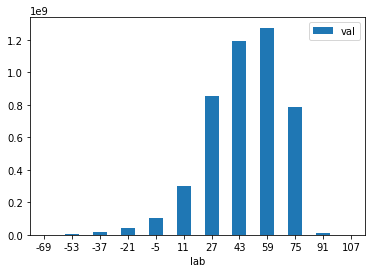

In [77]:
%%time
makeHistogram(-69.0,110.0,11,'mean_temp')
# Looking at the values on the x-axis, it makes sense that US temperatures would fall into this range

CPU times: user 76 ms, sys: 12 ms, total: 88 ms
Wall time: 57.8 s


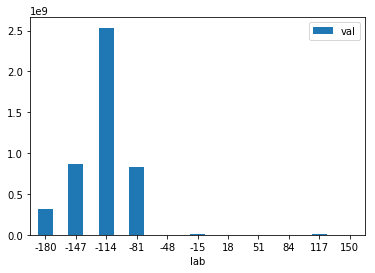

In [76]:
%%time
makeHistogram(-179.63,179.583,11,'lon')
# Again, looking at the values on the x-axis, it makes sense that US longitudes would fall into this range

CPU times: user 68 ms, sys: 20 ms, total: 88 ms
Wall time: 54.8 s


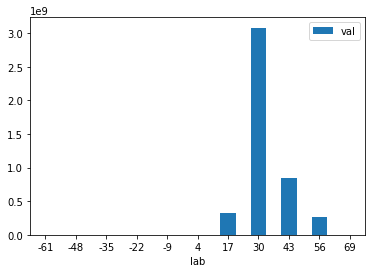

In [78]:
%%time
makeHistogram(-60.483,80.13,11,'lat')
# Again, looking at the values on the x-axis, it makes sense that US latitudes would fall into this range

### Using the RDD method (below) took almost an hour to run for a single plot. Even after caching the temp DF. Bummer.

In [ ]:
# %%time
# temp_hist = temp.select('mean_temp').rdd.flatMap(lambda x: x).histogram(11)
# plot_hist(temp_hist)

<img src="../screenshots/lost-proxy.png">

In [66]:
# %%time
# temp_hist = temp.select('lon').rdd.flatMap(lambda x: x).histogram(11)

# # Loading the Computed Histogram into a Pandas Dataframe for plotting
# plot_hist(temp_hist)

In [67]:
# %%time
# temp_hist = temp.select('lat').rdd.flatMap(lambda x: x).histogram(11)

# # Loading the Computed Histogram into a Pandas Dataframe for plotting
# plot_hist(temp_hist)

# Exercise 5 - Analysis

In this section we're going to perform some aggregations to answer the question of "Is there global warming?" Don't take it too seriously, it's just an exercise! We're going to prepare our data so that we can draw an interactive graph displaying the change in avarage temperatures over time, as a function of latitude.



<img src="temp-table-01.png">

In [79]:
# let's use a struct to build a composite key. The struct allows us to preserve the individual columns 
# while giving us the ability to use the composite to do a groupBy
temp = temp.withColumn('time-lat', F.struct('time','lat'))
daily_average_at_latitude = temp.select('time-lat','mean_temp').groupBy("time-lat").agg(F.avg('mean_temp'))

If you’re used to RDDs you might be concerned by groupBy, but it is now a safe operation on thanks to the Spark SQL DataFrames optimizer, which automatically pipelines our reductions, avoiding giant shuffles and mega records. (HP Spark, pg. 43)

In [80]:
daily_average_at_latitude.printSchema()

root
 |-- time-lat: struct (nullable = false)
 |    |-- time: timestamp (nullable = true)
 |    |-- lat: double (nullable = true)
 |-- avg(mean_temp): double (nullable = true)



<img src="time-lat-avg2.png">

In [81]:
# this function is here to make it easier to reason with the column names, flattens structs
def flatten_df(nested_df):
    flat_cols = [c[0] for c in nested_df.dtypes if c[1][:6] != 'struct']
    nested_cols = [c[0] for c in nested_df.dtypes if c[1][:6] == 'struct']

    flat_df = nested_df.select(flat_cols +
                               [F.col(nc+'.'+c).alias(nc+'_'+c)
                                for nc in nested_cols
                                for c in nested_df.select(nc+'.*').columns])
    return flat_df

In [82]:
daily_average_at_latitude = flatten_df(daily_average_at_latitude)

In [83]:
daily_average_at_latitude.printSchema()

root
 |-- avg(mean_temp): double (nullable = true)
 |-- time-lat_time: timestamp (nullable = true)
 |-- time-lat_lat: double (nullable = true)



In [84]:
# Now let's get the average on each latitude. 
# Latitudes are very granular, so it makes sense to round them and group by these coarser values
daily_average_at_latitude = daily_average_at_latitude.withColumn('time-rounded-lat', F.struct('time-lat_time',F.round(daily_average_at_latitude['time-lat_lat'],0)))
average_by_lat = daily_average_at_latitude.groupby('time-rounded-lat').agg(F.avg('avg(mean_temp)'))

In [85]:
# we used the struct in order to do a simple groupby that we can flatten again to get information
average_by_lat.printSchema()

root
 |-- time-rounded-lat: struct (nullable = false)
 |    |-- time-lat_time: timestamp (nullable = true)
 |    |-- col2: double (nullable = true)
 |-- avg(avg(mean_temp)): double (nullable = true)



In [86]:
# the names weren't very descriptive, let's rework that
average_by_lat = flatten_df(average_by_lat)
average_by_lat = average_by_lat.withColumnRenamed('time-rounded-lat_col2', 'rounded-lat')
average_by_lat = average_by_lat.withColumnRenamed('time-rounded-lat_time-lat_time', 'time')
average_by_lat = average_by_lat.withColumnRenamed('avg(avg(mean_temp))', 'temp')
average_by_lat.printSchema()

root
 |-- temp: double (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- rounded-lat: double (nullable = true)



In [87]:
# oh man that's a lot of stuff and since we can't cache the data this is taking forever to run.
average_by_lat.explain()

== Physical Plan ==
*(4) HashAggregate(keys=[time-rounded-lat#1176], functions=[avg(avg(mean_temp)#1162)])
+- Exchange hashpartitioning(time-rounded-lat#1176, 200)
   +- *(3) HashAggregate(keys=[time-rounded-lat#1176], functions=[partial_avg(avg(mean_temp)#1162)])
      +- *(3) HashAggregate(keys=[time-lat#1150], functions=[avg(mean_temp#364)])
         +- Exchange hashpartitioning(time-lat#1150, 200)
            +- *(2) HashAggregate(keys=[time-lat#1150], functions=[partial_avg(mean_temp#364)])
               +- *(2) Project [named_struct(time, time#134, lat, cast(lat#183 as double)) AS time-lat#1150, cast(mean_temp#77 as double) AS mean_temp#364]
                  +- *(2) BroadcastHashJoin [station_number#72], [usaf#177], Inner, BuildRight
                     :- *(2) Project [station_number#72, mean_temp#77, cast(concat(year#74, -, month#75, -, day#76) as timestamp) AS time#134]
                     :  +- *(2) Filter isnotnull(station_number#72)
                     :     +- *(2) Fi

In [89]:
# Let's avoid doing all that ^^ work multiple times.
# Let's output to file and then read from that file to reduce our load for next time.
average_by_lat.write.format("parquet").save("gs://w261-bucket/gsod/average_by_lat.parquet")
average_by_lat_read = spark.read.parquet("gs://w261-bucket/gsod/average_by_lat.parquet")

In [90]:
# I didn't time this, but it took about 17 minutes to save this to parquet

In [91]:
average_by_lat_read.explain()

== Physical Plan ==
*(1) FileScan parquet [temp#1232,time#1233,rounded-lat#1234] Batched: true, Format: Parquet, Location: InMemoryFileIndex[gs://w261-bucket/gsod/average_by_lat.parquet], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<temp:double,time:timestamp,rounded-lat:double>


In [92]:
average_by_lat_read.show(10)

+------------------+-------------------+-----------+
|              temp|               time|rounded-lat|
+------------------+-------------------+-----------+
| 38.35000038146973|1940-02-06 00:00:00|       42.0|
| 33.30499963760376|1940-02-26 00:00:00|       34.0|
| 55.57837769791887|1940-04-14 00:00:00|       47.0|
|  36.2037037037037|1940-12-04 00:00:00|       47.0|
| 58.36562327047188|1941-10-05 00:00:00|       46.0|
| 31.97604179879028|1941-12-09 00:00:00|       45.0|
|23.598311814626058|1942-01-02 00:00:00|       39.0|
| 33.36927065253258|1942-01-23 00:00:00|       45.0|
|43.910237752823605|1942-03-23 00:00:00|       41.0|
| 53.94781947502723|1942-10-25 00:00:00|       38.0|
+------------------+-------------------+-----------+
only showing top 10 rows



In [93]:
# Small enough to fit in pandas for our final analysis. Let's do that. Pandas is really fast, 
# and if your dataset is small enough to run locally in pandas, do that!
average_by_lat_read.count()

1418384

In [94]:
df = average_by_lat_read.toPandas()

In [95]:
df.head()

,temp,time,rounded-lat
0,38.350000,1940-02-06,42.0
1,33.305000,1940-02-26,34.0
2,55.578378,1940-04-14,47.0
3,36.203704,1940-12-04,47.0
4,58.365623,1941-10-05,46.0


In [96]:
df = df.set_index(['rounded-lat','time'])

In [97]:
df = df.sort_index()

In [98]:
df.head()

temp
rounded-lat time                 
-60.0       1943-08-01  55.000000
            1943-08-02  56.200001
            1943-08-03  60.099998
            1943-08-04  56.700001
            1943-08-05  57.700001

In [99]:
lat_list = df.index.levels[0]
print(lat_list)

Float64Index([-60.0, -35.0, -32.0, -18.0, -10.0,   0.0,   4.0,   6.0,   9.0,
               15.0,  17.0,  18.0,  19.0,  20.0,  21.0,  22.0,  23.0,  24.0,
               25.0,  26.0,  27.0,  28.0,  29.0,  30.0,  31.0,  32.0,  33.0,
               34.0,  35.0,  36.0,  37.0,  38.0,  39.0,  40.0,  41.0,  42.0,
               43.0,  44.0,  45.0,  46.0,  47.0,  48.0,  49.0,  50.0,  51.0,
               52.0,  53.0,  54.0,  55.0,  56.0,  57.0,  58.0,  59.0,  60.0,
               61.0,  62.0,  63.0,  64.0,  65.0,  66.0,  67.0,  68.0,  69.0,
               70.0,  71.0,  72.0,  80.0],
             dtype='float64', name='rounded-lat')


In [17]:
# Is temperature increasing? Data isn't very clean and we didn't perform any sensor corrections.
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

n_roll = 365
def f(x):
    df.loc[x].rolling(n_roll).mean().plot()

interact(f, x=lat_list);

## Below is just a screenshot of the chart. To see the ineractive chart, follow the instructions below

<img src="../screenshots/plot-screenshot.png">

> __DISCUSSION QUESTIONS:__
* Why did we create a struct for our groupBy?
* Why did we push our transformations to a file and load them again? - compare and contrast cache(), save to disk (checkpoint), saveManagedTable
* Where could we have done this before to save computation time?
* Why did we do a rolling average of temperature?
* Isn't pandas a lot easier to use?

__INSTRUCTOR TALKING POINTS__
* Why did we create a struct for our groupBy?
> This allowed us to create a composite key that we can access the original keys in a seamless fashion

* Why did we push our transformations to a file and load them again?
> This offload allowed us to have non-repeated computation once we went through the transformation steps. 

* Where could we have done this before to save computation time?
> We could have done a similar file offload prior to generating our histograms that repeated the computation 3x.

* Why did we do a rolling average of the temprature?
> We only care about the long term change in temperature and the day to day variations are dependent on various weather effects such as rain or clouds.

* Isn't pandas a lot easier to use?
> Yes, but it also has significant limitations in comparison to the raw data we're able to process with Spark. 


In [ ]:
# lets save this df for later plotting, just in case. We're still in the cloud here.
df.to_csv("pandas.csv")

In [ ]:
# now download the file to local machine
!gcloud compute scp w261-demo-m:/pandas.csv ~/MyDocuments/UCB/w261/Instructors/LiveSessionMaterials/wk08Demo_DataFrames/data

# SKIP THIS unless you want to render the chart while working locally:
IMPORTANT: We are now on the local machine. Jupyter lab does not support matplotlib notebook. To view the chart, open in jupyter notebook.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("pandas.csv")

In [3]:
df.head()

,rounded-lat,time,temp
0,-60.0,1943-08-01,55.000000
1,-60.0,1943-08-02,56.200001
2,-60.0,1943-08-03,60.099998
3,-60.0,1943-08-04,56.700001
4,-60.0,1943-08-05,57.700001


In [4]:
df = df.set_index(['rounded-lat','time'])

In [5]:
df = df.sort_index()

In [6]:
lat_list = df.index.levels[0]
print(lat_list)

Float64Index([-60.0, -35.0, -32.0, -18.0, -10.0,   0.0,   4.0,   6.0,   9.0,
               15.0,  17.0,  18.0,  19.0,  20.0,  21.0,  22.0,  23.0,  24.0,
               25.0,  26.0,  27.0,  28.0,  29.0,  30.0,  31.0,  32.0,  33.0,
               34.0,  35.0,  36.0,  37.0,  38.0,  39.0,  40.0,  41.0,  42.0,
               43.0,  44.0,  45.0,  46.0,  47.0,  48.0,  49.0,  50.0,  51.0,
               52.0,  53.0,  54.0,  55.0,  56.0,  57.0,  58.0,  59.0,  60.0,
               61.0,  62.0,  63.0,  64.0,  65.0,  66.0,  67.0,  68.0,  69.0,
               70.0,  71.0,  72.0,  80.0],
             dtype='float64', name='rounded-lat')


In [7]:
# Is temperature increasing? Data isn't very clean and we didn't perform any sensor corrections.
%matplotlib notebook
#%matplotlib inline
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

n_roll = 365
def f(x):
    df.loc[x].rolling(n_roll).mean().plot()

interact(f, x=lat_list);

interactive(children=(Dropdown(description='x', options=(-60.0, -35.0, -32.0, -18.0, -10.0, 0.0, 4.0, 6.0, 9.0…